In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
RANDOM_SEED = 42
TRAIN_CASE = 'daily_Confirmed'
TRAIN_LOCATION="Kerala"
TRAIN_LOCATION1="Delhi"
TRAIN_LOCATION2="Tamil Nadu"
DATATRAIN_SOURCE_FILE ='covid_19_india.csv'
TEST_SIZE = 0.3
LOOK_BACK = 1
BATCH_SIZE = 1
EPOCHS = 500
DAYS_TO_PREDICT = 30

In [3]:
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(DATATRAIN_SOURCE_FILE)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [6]:
nan_values_array = []
for column in df:
     nan_values_array.append(df[column].isnull().sum())

In [7]:
column_names = list(df.columns.values)
data = {'Feature':column_names,'Number of NaN values':nan_values_array}
nan_values = pd.DataFrame(data)
print(nan_values)

                    Feature  Number of NaN values
0                       Sno                     0
1                      Date                     0
2                      Time                     0
3      State/UnionTerritory                     0
4   ConfirmedIndianNational                     0
5  ConfirmedForeignNational                     0
6                     Cured                     0
7                    Deaths                     0
8                 Confirmed                     0


In [8]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")

In [9]:
ex = np.unique(df['State/UnionTerritory'])
ex

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Bihar****',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Himanchal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karanataka', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Madhya Pradesh***', 'Maharashtra',
       'Maharashtra***', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Telengana', 'Tripura', 'Unassigned',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [10]:
def clean_stateName(stateName):
    if stateName == 'Telangana':
        stateName = 'Telangana'
    elif stateName == 'Telengana':
        stateName = 'Telangana'  
    elif stateName == 'Bihar****':
        stateName = 'Bihar'
    elif stateName == 'Himanchal Pradesh':
        stateName = 'Himachal Pradesh'
    elif stateName == 'Karanataka':
        stateName = 'Karnataka'
    elif stateName == 'Madhya Pradesh***':
        stateName = 'Madhya Pradesh'
    elif stateName == 'Maharashtra***':
        stateName = 'Maharashtra'
    return stateName

In [11]:
df["State/UnionTerritory"] = df["State/UnionTerritory"].apply(lambda x: clean_stateName(x))
np.unique(df["State/UnionTerritory"]) 

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Unassigned', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [12]:
def daily_cases(dframe, stateColumn,dateColumn, cummColumn):
    
    dframe.sort_values(by = [stateColumn, dateColumn], inplace = True)
    newColName = 'daily_' + cummColumn
    dframe[newColName] = dframe[cummColumn].diff() 

    mask = dframe[stateColumn] != dframe[stateColumn].shift(1)
    dframe[newColName][mask] = np.nan
    dframe[newColName] = dframe[newColName].apply(lambda x: 0 if x < 0 else x)
    
    return dframe

In [13]:
df_new = daily_cases(dframe= df, stateColumn= 'State/UnionTerritory',dateColumn= 'Date', cummColumn= 'Confirmed')

C:\Users\sephy\AppData\Local\Temp/ipykernel_19472/2511789098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe[newColName][mask] = np.nan


In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [15]:
df_new['daily_Confirmed'].fillna(value=df_new['daily_Confirmed'].mean(),inplace=True)

In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [17]:
corrmat=df_new.corr()[df_new.corr(method='pearson')>0.6]                  
print(corrmat)


                 Sno     Cured    Deaths  Confirmed  daily_Confirmed
Sno              1.0       NaN       NaN        NaN              NaN
Cured            NaN  1.000000  0.917529   0.997751              NaN
Deaths           NaN  0.917529  1.000000   0.918346              NaN
Confirmed        NaN  0.997751  0.918346   1.000000              NaN
daily_Confirmed  NaN       NaN       NaN        NaN              1.0


In [18]:
def correlation(dataset, threshold): 
    col_corr = set() 
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold): 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr
#    
corr_feature=correlation(df,0.6)
len(set(corr_feature))


2

In [19]:
corr_feature

{'Confirmed', 'Deaths'}

In [20]:
df_new.drop(['Confirmed','Deaths'],axis=1,inplace=True)

In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [22]:

if TRAIN_LOCATION2:
    df_new = df_new.loc[df_new['State/UnionTerritory']==TRAIN_LOCATION2]


In [23]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 61 to 18104
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       523 non-null    int64         
 1   Date                      523 non-null    datetime64[ns]
 2   Time                      523 non-null    object        
 3   State/UnionTerritory      523 non-null    object        
 4   ConfirmedIndianNational   523 non-null    object        
 5   ConfirmedForeignNational  523 non-null    object        
 6   Cured                     523 non-null    int64         
 7   daily_Confirmed           523 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 36.8+ KB


Gettin train case & removing all zero values

In [24]:
cases = df_new.filter([TRAIN_CASE])
cases = cases[(cases.T != 0).any()]

In [25]:
cases.head()

,daily_Confirmed
61,1777.163863
220,1.000000
240,1.000000
285,4.000000
308,2.000000


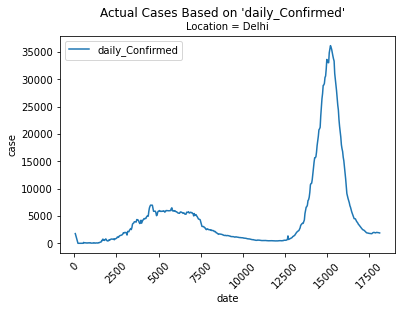

In [26]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [27]:
cases.shape

(509, 1)

In [28]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [29]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [30]:
train_cases.shape

(357, 1)

In [31]:
test_cases.shape

(152, 1)

In [32]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [33]:
all_cases.shape

(509, 1)

In [34]:
train_cases.shape

(357, 1)

In [35]:
test_cases.shape

(152, 1)

In [36]:
look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

In [37]:
X_all.shape

(507, 1)

In [38]:
X_train.shape

(355, 1)

In [39]:
X_test.shape

(150, 1)

In [40]:
X_all = np.array(X_all).reshape(X_all.shape[0], 1, 1)
Y_all = np.array(Y_all).reshape(Y_all.shape[0], 1)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, 1)
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 1, 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

In [41]:
X_all.shape

(507, 1, 1)

In [42]:
Y_all.shape

(507, 1)

In [43]:
X_train.shape

(355, 1, 1)

In [44]:
Y_train.shape

(355, 1)

In [45]:
X_test.shape

(150, 1, 1)

In [46]:
Y_test.shape

(150, 1)

In [47]:
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

batch_size = BATCH_SIZE
model = Sequential()
model.add(LSTM(128, return_sequences=True, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=True))
model.add(Dropout(0.10))
model.add(LSTM(64, stateful=True))
model.add(Dropout(0.10))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 128)               66560     
                                                                 
 dropout (Dropout)           (1, 1, 128)               0         
                                                                 
 lstm_1 (LSTM)               (1, 64)                   49408     
                                                                 
 dropout_1 (Dropout)         (1, 64)                   0         
                                                                 
 dense (Dense)               (1, 1)                    65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\sephy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_train, Y_train, batch_size=1, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    
    model.reset_states()

Iteration 1/500
355/355 [==============================] - 8s 6ms/step - loss: 0.0567
Iteration 2/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0130
Iteration 3/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0080
Iteration 4/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0050
Iteration 5/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0042
Iteration 6/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0034
Iteration 7/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0024
Iteration 8/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0021
Iteration 9/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0022
Iteration 10/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0019
Iteration 11/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0021
Iteration 12/500
355/355 [==========================

355/355 [==============================] - 2s 5ms/step - loss: 0.0012
Iteration 96/500
355/355 [==============================] - 2s 5ms/step - loss: 9.4392e-04
Iteration 97/500
355/355 [==============================] - 2s 6ms/step - loss: 8.9677e-04
Iteration 98/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0010
Iteration 99/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0010
Iteration 100/500
355/355 [==============================] - 2s 5ms/step - loss: 9.8224e-04
Iteration 101/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0011
Iteration 102/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0011
Iteration 103/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0013
Iteration 104/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0011
Iteration 105/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0012
Iteration 106/500
355/355 [===============

355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 189/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0016
Iteration 190/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 191/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 192/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0016
Iteration 193/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0015
Iteration 194/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 195/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0013
Iteration 196/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 197/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 198/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0014
Iteration 199/500
355/355 [=======================

355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 282/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0014
Iteration 283/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 284/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0014
Iteration 285/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0016
Iteration 286/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0016
Iteration 287/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0014
Iteration 288/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0016
Iteration 289/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 290/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0014
Iteration 291/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0014
Iteration 292/500
355/355 [=======================

355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 375/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 376/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 377/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0016
Iteration 378/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0015
Iteration 379/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 380/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0017
Iteration 381/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0022
Iteration 382/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0015
Iteration 383/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0017
Iteration 384/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0014
Iteration 385/500
355/355 [=======================

355/355 [==============================] - 2s 6ms/step - loss: 0.0050
Iteration 468/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0067
Iteration 469/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0062
Iteration 470/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0026
Iteration 471/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0034
Iteration 472/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0035
Iteration 473/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0043
Iteration 474/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0062
Iteration 475/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0077
Iteration 476/500
355/355 [==============================] - 2s 6ms/step - loss: 0.0079
Iteration 477/500
355/355 [==============================] - 2s 5ms/step - loss: 0.0082
Iteration 478/500
355/355 [=======================

Plotting model loss history

Lower `loss` provide better prediction

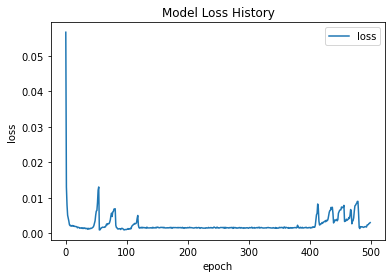

In [49]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [50]:
train_predict = model.predict(X_train, batch_size=batch_size)

355/355 [==============================] - 3s 3ms/step


In [51]:
days_to_predict = X_test.shape[0]
test_predict = []
pred_samples = train_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(X_test[i:(i+1)], batch_size=batch_size)
    pred = np.array(pred).flatten()
    test_predict.append(pred)
test_predict = np.array(test_predict).reshape(1, len(test_predict), 1)

1/1 [==============================] - 0s 40ms/step


In [52]:
model.reset_states()

In [53]:
X_train_flatten = np.array(scaler.inverse_transform(
    np.array(X_train).reshape(X_train.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten = np.array(scaler.inverse_transform(
    np.array(Y_train).reshape(Y_train.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten = np.array(scaler.inverse_transform(
    np.array(train_predict).reshape(train_predict.shape[0], 1)
)).flatten().astype('int')
X_test_flatten = np.array(scaler.inverse_transform(
    np.array(X_test).reshape(X_test.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten = np.array(scaler.inverse_transform(
    np.array(Y_test).reshape(Y_test.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten = np.array(scaler.inverse_transform(
    np.array(test_predict).reshape(test_predict.shape[1], 1)
)).flatten().astype('int')

In [54]:
model.reset_states()

In [55]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_all, Y_all, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    
    model.reset_states()

Iteration 1/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1137
Iteration 2/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1145
Iteration 3/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1331
Iteration 4/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1248
Iteration 5/500
507/507 [==============================] - 3s 5ms/step - loss: 0.1305
Iteration 6/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1425
Iteration 7/500
507/507 [==============================] - 3s 5ms/step - loss: 0.1441
Iteration 8/500
507/507 [==============================] - 3s 5ms/step - loss: 0.1439
Iteration 9/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1587
Iteration 10/500
507/507 [==============================] - 3s 6ms/step - loss: 0.1427
Iteration 11/500
507/507 [==============================] - 3s 5ms/step - loss: 0.1456
Iteration 12/500
507/507 [==========================

507/507 [==============================] - 3s 6ms/step - loss: 0.0057
Iteration 96/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0054
Iteration 97/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0047
Iteration 98/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0059
Iteration 99/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0040
Iteration 100/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0048
Iteration 101/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0083
Iteration 102/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0222
Iteration 103/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0098
Iteration 104/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0141
Iteration 105/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0136
Iteration 106/500
507/507 [===========================

507/507 [==============================] - 3s 5ms/step - loss: 0.0042
Iteration 189/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0031
Iteration 190/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0026
Iteration 191/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0025
Iteration 192/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0042
Iteration 193/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0028
Iteration 194/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0091
Iteration 195/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0066
Iteration 196/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0046
Iteration 197/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0040
Iteration 198/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0033
Iteration 199/500
507/507 [=======================

507/507 [==============================] - 3s 5ms/step - loss: 0.0025
Iteration 282/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0022
Iteration 283/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0030
Iteration 284/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0026
Iteration 285/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0018
Iteration 286/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0029
Iteration 287/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0032
Iteration 288/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0042
Iteration 289/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0023
Iteration 290/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0027
Iteration 291/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0023
Iteration 292/500
507/507 [=======================

507/507 [==============================] - 3s 6ms/step - loss: 0.0027
Iteration 375/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0020
Iteration 376/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0030
Iteration 377/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0042
Iteration 378/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0031
Iteration 379/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0023
Iteration 380/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0026
Iteration 381/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0025
Iteration 382/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0027
Iteration 383/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0019
Iteration 384/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0027
Iteration 385/500
507/507 [=======================

507/507 [==============================] - 3s 6ms/step - loss: 0.0043
Iteration 468/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0030
Iteration 469/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0026
Iteration 470/500
507/507 [==============================] - 3s 5ms/step - loss: 0.0025
Iteration 471/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0030
Iteration 472/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0043
Iteration 473/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0029
Iteration 474/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0018
Iteration 475/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0026
Iteration 476/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0024
Iteration 477/500
507/507 [==============================] - 3s 6ms/step - loss: 0.0024
Iteration 478/500
507/507 [=======================

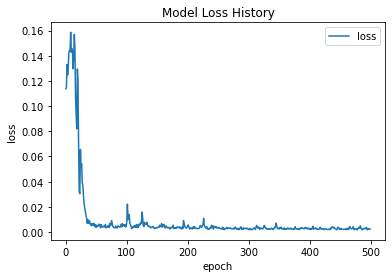

In [56]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [57]:
all_predict = model.predict(X_all, batch_size=batch_size)

507/507 [==============================] - 2s 3ms/step


In [58]:
days_to_predict = DAYS_TO_PREDICT
future_predict = []
pred_samples = all_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(pred_samples, batch_size=batch_size)
    pred = np.array(pred).flatten()
    future_predict.append(pred)
    new_samples = np.array(pred_samples).flatten()
    new_samples = np.append(new_samples, [pred])
    new_samples = new_samples[1:]
    pred_samples = np.array(new_samples).reshape(1, 1, 1)
future_predict = np.array(future_predict).reshape(len(future_predict), 1, 1)

1/1 [==============================] - 0s 33ms/step


In [59]:
model.reset_states()

In [60]:
f_future_predict = model.predict(future_predict, batch_size=batch_size)

30/30 [==============================] - 0s 3ms/step


In [61]:
model.reset_states()

In [62]:
X_all_flatten = np.array(scaler.inverse_transform(
    np.array(X_all).reshape(X_all.shape[0], 1)
)).flatten().astype('int')
X_all_flatten = np.absolute(X_all_flatten)
Y_all_flatten = np.array(scaler.inverse_transform(
    np.array(Y_all).reshape(Y_all.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten = np.absolute(Y_all_flatten)
all_predict_flatten = np.array(scaler.inverse_transform(
    np.array(all_predict).reshape(all_predict.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.absolute(all_predict_flatten)
future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(future_predict).reshape(future_predict.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten = np.absolute(future_predict_flatten)
f_future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(f_future_predict).reshape(f_future_predict.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten = np.absolute(f_future_predict_flatten)

In [121]:
future_index = pd.date_range(start=cases.index[-1], periods=days_to_predict + 1, closed='right')

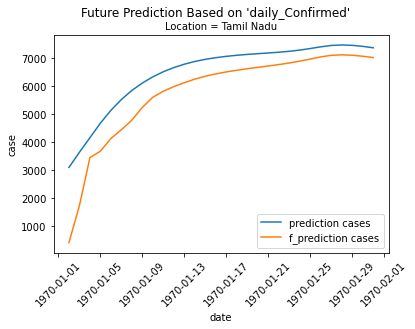

In [316]:
plt.plot(
    future_index,
    future_predict_flatten,
    label='prediction cases'
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION2, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Plotting f_future prediction visualization

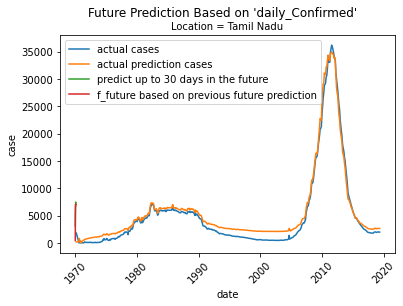

In [317]:
plt.plot(
    cases.index[:len(X_all_flatten)],
    X_all_flatten,
    label='actual cases'
)
plt.plot(
    cases.index[:len(X_all_flatten)],
    all_predict_flatten,
    label='actual prediction cases'
)
plt.plot(
    future_index,
    future_predict_flatten,
    label='predict up to ' + str(days_to_predict) + ' days in the future'
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION2, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [348]:
#tn
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i]):
            count += 1
           
    return count/len(DataY)
accuracy( Y_all_flatten, 
        all_predict_flatten)

0.9329388560157791

In [125]:
df1= pd.read_csv(DATATRAIN_SOURCE_FILE)


In [126]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [127]:
df1["Date"] = pd.to_datetime(df1["Date"], format = "%Y-%m-%d")

In [128]:
ex = np.unique(df1['State/UnionTerritory'])
ex

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Bihar****',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Himanchal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karanataka', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Madhya Pradesh***', 'Maharashtra',
       'Maharashtra***', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Telengana', 'Tripura', 'Unassigned',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [129]:
def clean_stateName(stateName):
    if stateName == 'Telangana':
        stateName = 'Telangana'
    elif stateName == 'Telengana':
        stateName = 'Telangana'  
    elif stateName == 'Bihar****':
        stateName = 'Bihar'
    elif stateName == 'Himanchal Pradesh':
        stateName = 'Himachal Pradesh'
    elif stateName == 'Karanataka':
        stateName = 'Karnataka'
    elif stateName == 'Madhya Pradesh***':
        stateName = 'Madhya Pradesh'
    elif stateName == 'Maharashtra***':
        stateName = 'Maharashtra'
    return stateName

In [130]:
df1["State/UnionTerritory"] = df1["State/UnionTerritory"].apply(lambda x: clean_stateName(x))
np.unique(df1["State/UnionTerritory"]) # to identify all unique values in a column of dataframe or array

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Unassigned', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [131]:
def daily_cases(dframe, stateColumn,dateColumn, cummColumn):
    # Sort column containing state and then by date in ascending order
    dframe.sort_values(by = [stateColumn, dateColumn], inplace = True)
    newColName = 'daily_' + cummColumn
    dframe[newColName] = dframe[cummColumn].diff() # diff is pandas method to caclucate difference between consecutive values
#    print(dframe.tail())
    '''
    Below line uses shift method of pandas to compare consecutive state names and if they are not different
    as shown by using ! symbol then create list of boolean, True for if they are different else False
    ''' 
    mask = dframe[stateColumn] != dframe[stateColumn].shift(1)
    dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN
    dframe[newColName] = dframe[newColName].apply(lambda x: 0 if x < 0 else x) # replace negative values by 0
#     dframe.drop('diffs',axis=1, inplace = True)
    
    return dframe

In [132]:
df_new1 = daily_cases(dframe= df1, stateColumn= 'State/UnionTerritory',dateColumn= 'Date', cummColumn= 'Confirmed')

C:\Users\sephy\AppData\Local\Temp/ipykernel_26524/1035172673.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN


In [133]:
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [134]:
df_new1['daily_Confirmed'].fillna(value=df_new1['daily_Confirmed'].mean(),inplace=True)

In [135]:
corrmat=df_new1.corr()[df_new1.corr(method='pearson')>0.6]                  #Checking for highly correlated lab variables
print(corrmat)


                 Sno     Cured    Deaths  Confirmed  daily_Confirmed
Sno              1.0       NaN       NaN        NaN              NaN
Cured            NaN  1.000000  0.917529   0.997751              NaN
Deaths           NaN  0.917529  1.000000   0.918346              NaN
Confirmed        NaN  0.997751  0.918346   1.000000              NaN
daily_Confirmed  NaN       NaN       NaN        NaN              1.0


In [136]:
def correlation(dataset, threshold): 
    col_corr = set() 
    corr_matrix = df_new1.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold): 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr
#    
corr_feature=correlation(df_new1,0.6)
len(set(corr_feature))


2

In [137]:
df_new1.drop(['Confirmed','Deaths'],axis=1,inplace=True)

In [138]:
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [139]:
if TRAIN_LOCATION1:
    df_new1 = df_new1.loc[df_new1['State/UnionTerritory']==TRAIN_LOCATION1]

In [140]:
df_new1.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,daily_Confirmed
34,35,2020-03-02,6:00 PM,Delhi,1,0,0,1777.163863
38,39,2020-03-03,6:00 PM,Delhi,1,0,0,0.000000
42,43,2020-03-04,6:00 PM,Delhi,1,0,0,0.000000
45,46,2020-03-05,6:00 PM,Delhi,2,0,0,1.000000
51,52,2020-03-06,6:00 PM,Delhi,3,0,0,1.000000


In [141]:
cases1 = df_new1.filter([TRAIN_CASE])
cases1 = cases1[(cases1.T != 0).any()]


In [142]:
cases1.head()

,daily_Confirmed
34,1777.163863
45,1.000000
51,1.000000
84,1.000000
98,1.000000


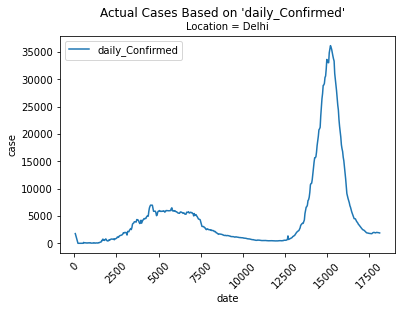

In [143]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [144]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [145]:
test_size1 = TEST_SIZE
test_size1 = int(cases1.shape[0] * test_size1)
train_cases1 = cases1[:-test_size1]
test_cases1 = cases1[-test_size1:]

In [146]:
train_cases1.shape


(359, 1)

In [147]:
test_cases1.shape

(153, 1)

In [148]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases1)
all_cases1 = scaler.transform(cases1)
train_cases1 = scaler.transform(train_cases1)
test_cases1 = scaler.transform(test_cases1)

In [149]:
all_cases1.shape

(512, 1)

In [150]:
train_cases1.shape

(359, 1)

In [151]:
test_cases1.shape

(153, 1)

In [152]:
look_back = LOOK_BACK
X_all1, Y_all1 = data_split(all_cases1, look_back=look_back)
X_train1, Y_train1 = data_split(train_cases1, look_back=look_back)
X_test1, Y_test1 = data_split(test_cases1, look_back=look_back)

In [153]:
X_all1.shape

(510, 1)

In [154]:
X_train1.shape

(357, 1)

In [155]:
X_test1.shape

(151, 1)

In [156]:
X_all1 = np.array(X_all1).reshape(X_all1.shape[0], 1, 1)
Y_all1 = np.array(Y_all1).reshape(Y_all1.shape[0], 1)
X_train1 = np.array(X_train1).reshape(X_train1.shape[0], 1, 1)
Y_train1 = np.array(Y_train1).reshape(Y_train1.shape[0], 1)
X_test1 = np.array(X_test1).reshape(X_test1.shape[0], 1, 1)
Y_test1 = np.array(Y_test1).reshape(Y_test1.shape[0], 1)

In [157]:
X_all1.shape

(510, 1, 1)

In [158]:
Y_all1.shape

(510, 1)

In [159]:
X_train1.shape

(357, 1, 1)

In [160]:
Y_test1.shape

(151, 1)

In [161]:
Y_train1.shape

(357, 1)

In [162]:
X_test1.shape

(151, 1, 1)

In [187]:
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

batch_size = BATCH_SIZE
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, 
               batch_input_shape=(batch_size, X_train1.shape[1], X_train1.shape[2]), 
               stateful=True))
model2.add(Dropout(0.10))
model2.add(LSTM(64, stateful=True))
model2.add(Dropout(0.10))
model2.add(Dense(Y_train1.shape[1]))
model2.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001))
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (1, 1, 128)               0         
                                                                 
 lstm_9 (LSTM)               (1, 64)                   49408     
                                                                 
 dropout_9 (Dropout)         (1, 64)                   0         
                                                                 
 dense_4 (Dense)             (1, 1)                    65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\sephy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [188]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model2.fit(X_train1, Y_train1, batch_size=1, 
              epochs=1, verbose=1, shuffle=False)
    h1 = model2.history
    loss.append(h1.history['loss'][0])
    
    model2.reset_states()

Iteration 1/500
357/357 [==============================] - 3s 2ms/step - loss: 0.0627
Iteration 2/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0143
Iteration 3/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0111
Iteration 4/500
357/357 [==============================] - 1s 4ms/step - loss: 0.0103
Iteration 5/500
357/357 [==============================] - 1s 4ms/step - loss: 0.0104
Iteration 6/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0094
Iteration 7/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0094
Iteration 8/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0103
Iteration 9/500
357/357 [==============================] - 1s 4ms/step - loss: 0.0096
Iteration 10/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0099
Iteration 11/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0090
Iteration 12/500
357/357 [==========================

357/357 [==============================] - 1s 3ms/step - loss: 0.0064
Iteration 189/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0053
Iteration 190/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0044
Iteration 191/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Iteration 192/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0044
Iteration 193/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0040
Iteration 194/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0038
Iteration 195/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0040
Iteration 196/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0051
Iteration 197/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0045
Iteration 198/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0043
Iteration 199/500
357/357 [=======================

357/357 [==============================] - 1s 3ms/step - loss: 0.0037
Iteration 375/500
357/357 [==============================] - 2s 4ms/step - loss: 0.0035
Iteration 376/500
357/357 [==============================] - 1s 4ms/step - loss: 0.0043
Iteration 377/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0030
Iteration 378/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0030
Iteration 379/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0033
Iteration 380/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0030
Iteration 381/500
357/357 [==============================] - 1s 4ms/step - loss: 0.0035
Iteration 382/500
357/357 [==============================] - 1s 3ms/step - loss: 0.0037
Iteration 383/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0030
Iteration 384/500
357/357 [==============================] - 1s 2ms/step - loss: 0.0030
Iteration 385/500
357/357 [=======================

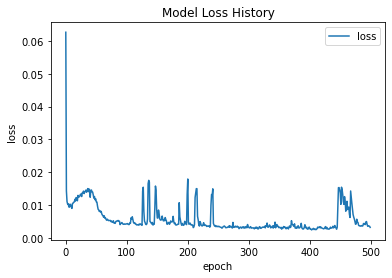

In [189]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [190]:
train_predict1= model2.predict(X_train1, batch_size=batch_size)

357/357 [==============================] - 1s 1ms/step


In [191]:
days_to_predict1 = X_test1.shape[0]
test_predict1 = []
pred_samples1 = train_predict1[-1:]
pred_samples1 = np.array([pred_samples1])
for i in range(days_to_predict1):
    pred1 = model2.predict(X_test1[i:(i+1)], batch_size=batch_size)
    pred1 = np.array(pred1).flatten()
    test_predict1.append(pred1)
test_predict1 = np.array(test_predict1).reshape(1, len(test_predict1), 1)

1/1 [==============================] - 0s 16ms/step


In [192]:
model2.reset_states()

In [193]:
X_train_flatten1 = np.array(scaler.inverse_transform(
    np.array(X_train1).reshape(X_train1.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten1 = np.array(scaler.inverse_transform(
    np.array(Y_train1).reshape(Y_train1.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(train_predict1).reshape(train_predict1.shape[0], 1)
)).flatten().astype('int')
X_test_flatten1 = np.array(scaler.inverse_transform(
    np.array(X_test1).reshape(X_test1.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten1 = np.array(scaler.inverse_transform(
    np.array(Y_test1).reshape(Y_test1.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(test_predict1).reshape(test_predict1.shape[1], 1)
)).flatten().astype('int')

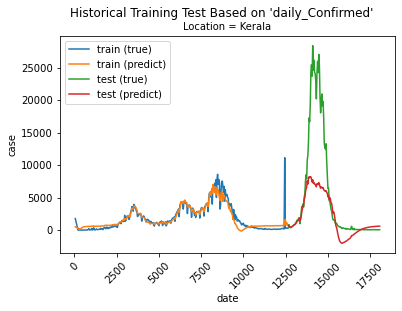

In [194]:
plt.plot(
    cases.index[:len(X_train_flatten1)],
    X_train_flatten1,
    label='train (true)'
)
plt.plot(
    cases.index[:len(train_predict_flatten1)],
    train_predict_flatten1,
    label='train (predict)'
)
plt.plot(
    cases.index[len(X_train_flatten1):len(X_train_flatten1) + len(X_test_flatten1)],
    X_test_flatten1,
    label='test (true)'
)
plt.plot(
    cases.index[len(X_train_flatten1):len(X_train_flatten1) + len(test_predict_flatten1)],
    test_predict_flatten1,
    label='test (predict)'
)
plt.suptitle('Historical Training Test Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [195]:
model2.reset_states()

In [196]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model2.fit(X_all1, Y_all1, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h1 = model2.history
    loss.append(h1.history['loss'][0])
    
    model2.reset_states()

Iteration 1/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0162
Iteration 2/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0494
Iteration 3/500
510/510 [==============================] - 2s 4ms/step - loss: 0.0336
Iteration 4/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0169
Iteration 5/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0147
Iteration 6/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0156
Iteration 7/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0081
Iteration 8/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0162
Iteration 9/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0187
Iteration 10/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0180
Iteration 11/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0101
Iteration 12/500
510/510 [==========================

510/510 [==============================] - 1s 3ms/step - loss: 0.0054
Iteration 189/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0067
Iteration 190/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0041
Iteration 191/500
510/510 [==============================] - 2s 3ms/step - loss: 0.0079
Iteration 192/500
510/510 [==============================] - 2s 3ms/step - loss: 0.0048
Iteration 193/500
510/510 [==============================] - 2s 4ms/step - loss: 0.0053
Iteration 194/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0046
Iteration 195/500
510/510 [==============================] - 2s 4ms/step - loss: 0.0064
Iteration 196/500
510/510 [==============================] - 2s 4ms/step - loss: 0.0042
Iteration 197/500
510/510 [==============================] - 2s 3ms/step - loss: 0.0040
Iteration 198/500
510/510 [==============================] - 2s 4ms/step - loss: 0.0054
Iteration 199/500
510/510 [=======================

510/510 [==============================] - 1s 3ms/step - loss: 0.0042
Iteration 375/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0050
Iteration 376/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0038
Iteration 377/500
510/510 [==============================] - 2s 3ms/step - loss: 0.0042
Iteration 378/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0033
Iteration 379/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 380/500
510/510 [==============================] - 1s 3ms/step - loss: 0.0056
Iteration 381/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0053
Iteration 382/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0054
Iteration 383/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0063
Iteration 384/500
510/510 [==============================] - 1s 2ms/step - loss: 0.0051
Iteration 385/500
510/510 [=======================

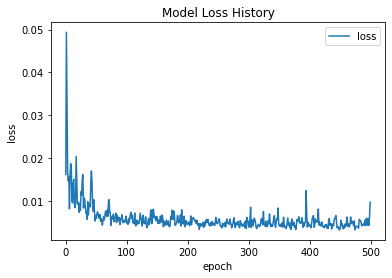

In [197]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [322]:
all_predict1 = model2.predict(X_all1, batch_size=batch_size)

510/510 [==============================] - 1s 2ms/step


In [323]:
days_to_predict1 = DAYS_TO_PREDICT
future_predict1 = []
pred_samples1 = all_predict1[-1:]
pred_samples1 = np.array([pred_samples1])
for i in range(days_to_predict1):
    pred1 = model2.predict(pred_samples1, batch_size=batch_size)
    pred1 = np.array(pred1).flatten()
    future_predict1.append(pred1)
    new_samples1 = np.array(pred_samples1).flatten()
    new_samples1 = np.append(new_samples1, [pred1])
    new_samples1 = new_samples1[1:]
    pred_samples1 = np.array(new_samples1).reshape(1, 1, 1)
future_predict1 = np.array(future_predict1).reshape(len(future_predict1), 1, 1)

1/1 [==============================] - 0s 22ms/step


In [324]:
model2.reset_states()

In [325]:
f_future_predict1 = model2.predict(future_predict1, batch_size=batch_size)

30/30 [==============================] - 0s 1ms/step


In [326]:
model2.reset_states()

In [327]:
X_all_flatten1 = np.array(scaler.inverse_transform(
    np.array(X_all1).reshape(X_all1.shape[0], 1)
)).flatten().astype('int')
X_all_flatten1 = np.absolute(X_all_flatten1)
Y_all_flatten1= np.array(scaler.inverse_transform(
    np.array(Y_all1).reshape(Y_all1.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten1 = np.absolute(Y_all_flatten1)
all_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(all_predict1).reshape(all_predict1.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten1 = np.absolute(all_predict_flatten1)
future_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(future_predict1).reshape(future_predict1.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten1 = np.absolute(future_predict_flatten1)
f_future_predict_flatten1 = np.array(scaler.inverse_transform(
    np.array(f_future_predict1).reshape(f_future_predict1.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten1 = np.absolute(f_future_predict_flatten1)

In [328]:
future_index1 = pd.date_range(start=cases1.index[-1], periods=days_to_predict1 + 1, closed='right')

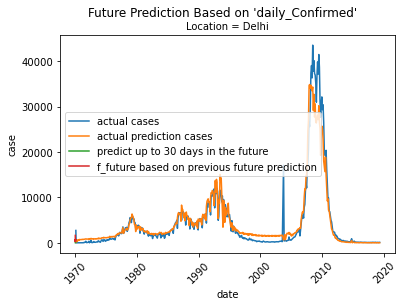

In [330]:
plt.plot(
    cases1.index[:len(X_all_flatten1)],
    X_all_flatten1,
    label='actual cases'
)
plt.plot(
    cases1.index[:len(X_all_flatten1)],
    all_predict_flatten1,
    label='actual prediction cases'
)
plt.plot(
    future_index1,
    future_predict_flatten1,
    label='predict up to ' + str(days_to_predict1) + ' days in the future'
)
plt.plot(
    future_index1,
    f_future_predict_flatten1,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION1, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [346]:
#delhi
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i]<7):
            count += 1
           
    return count/len(DataY)
accuracy( Y_all_flatten1, 
        all_predict_flatten1)

C:\Users\sephy\AppData\Local\Temp/ipykernel_26524/2636612167.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  if( (preds[i] - DataY[i])/DataY[i]<7):


0.9235294117647059

In [230]:
df3= pd.read_csv(DATATRAIN_SOURCE_FILE)


In [231]:
df3["Date"] = pd.to_datetime(df3["Date"], format = "%Y-%m-%d")

In [232]:
ex = np.unique(df3['State/UnionTerritory'])
ex

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Bihar****',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Himanchal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karanataka', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Madhya Pradesh***', 'Maharashtra',
       'Maharashtra***', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Telengana', 'Tripura', 'Unassigned',
       'Uttar Pradesh', 'Uttarakhand', 'West Bengal'], dtype=object)

In [233]:
def clean_stateName(stateName):
    if stateName == 'Telangana':
        stateName = 'Telangana'
    elif stateName == 'Telengana':
        stateName = 'Telangana'  
    elif stateName == 'Bihar****':
        stateName = 'Bihar'
    elif stateName == 'Himanchal Pradesh':
        stateName = 'Himachal Pradesh'
    elif stateName == 'Karanataka':
        stateName = 'Karnataka'
    elif stateName == 'Madhya Pradesh***':
        stateName = 'Madhya Pradesh'
    elif stateName == 'Maharashtra***':
        stateName = 'Maharashtra'
    return stateName

In [234]:
df3["State/UnionTerritory"] = df3["State/UnionTerritory"].apply(lambda x: clean_stateName(x))
np.unique(df3["State/UnionTerritory"]) # to identify all unique values in a column of dataframe or array

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar',
       'Cases being reassigned to states', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Unassigned', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [235]:
def daily_cases(dframe, stateColumn,dateColumn, cummColumn):
    # Sort column containing state and then by date in ascending order
    dframe.sort_values(by = [stateColumn, dateColumn], inplace = True)
    newColName = 'daily_' + cummColumn
    dframe[newColName] = dframe[cummColumn].diff() # diff is pandas method to caclucate difference between consecutive values
#    print(dframe.tail())
    '''
    Below line uses shift method of pandas to compare consecutive state names and if they are not different
    as shown by using ! symbol then create list of boolean, True for if they are different else False
    ''' 
    mask = dframe[stateColumn] != dframe[stateColumn].shift(1)
    dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN
    dframe[newColName] = dframe[newColName].apply(lambda x: 0 if x < 0 else x) # replace negative values by 0
#     dframe.drop('diffs',axis=1, inplace = True)
    
    return dframe

In [236]:
df_new3 = daily_cases(dframe= df3, stateColumn= 'State/UnionTerritory',dateColumn= 'Date', cummColumn= 'Confirmed')

C:\Users\sephy\AppData\Local\Temp/ipykernel_26524/1035172673.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe[newColName][mask] = np.nan # where value of mask =True the cell value will be replaced by NaN


In [237]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   Deaths                    18110 non-null  int64         
 8   Confirmed                 18110 non-null  int64         
 9   daily_Confirmed           18070 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 1.5+ MB


In [238]:
df_new3['daily_Confirmed'].fillna(value=df_new3['daily_Confirmed'].mean(),inplace=True)

In [239]:
corrmat=df_new3.corr()[df_new3.corr(method='pearson')>0.6]                  #Checking for highly correlated lab variables
print(corrmat)


                 Sno     Cured    Deaths  Confirmed  daily_Confirmed
Sno              1.0       NaN       NaN        NaN              NaN
Cured            NaN  1.000000  0.917529   0.997751              NaN
Deaths           NaN  0.917529  1.000000   0.918346              NaN
Confirmed        NaN  0.997751  0.918346   1.000000              NaN
daily_Confirmed  NaN       NaN       NaN        NaN              1.0


In [240]:
def correlation(dataset, threshold): 
    col_corr = set() 
    corr_matrix = df_new3.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] > threshold): 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr
#    
corr_feature=correlation(df_new3,0.6)
len(set(corr_feature))


2

In [241]:
df_new3.drop(['Confirmed','Deaths'],axis=1,inplace=True)

In [242]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18110 entries, 365 to 18109
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18110 non-null  int64         
 1   Date                      18110 non-null  datetime64[ns]
 2   Time                      18110 non-null  object        
 3   State/UnionTerritory      18110 non-null  object        
 4   ConfirmedIndianNational   18110 non-null  object        
 5   ConfirmedForeignNational  18110 non-null  object        
 6   Cured                     18110 non-null  int64         
 7   daily_Confirmed           18110 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [243]:
if TRAIN_LOCATION:
    df_new3 = df_new3.loc[df_new3['State/UnionTerritory']==TRAIN_LOCATION]

In [244]:
df_new3.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,daily_Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,1777.163863
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0.000000
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,1.000000
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,1.000000
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0.000000


In [245]:
cases3 = df_new3.filter([TRAIN_CASE])
cases3 = cases3[(cases3.T != 0).any()]
cases3.head()

,daily_Confirmed
0,1777.163863
2,1.000000
3,1.000000
69,5.000000
75,1.000000


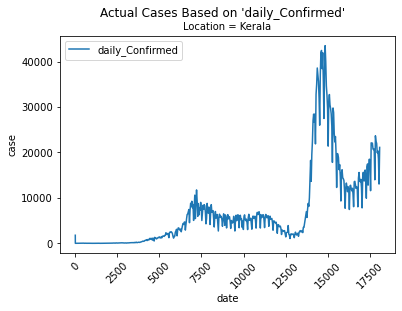

In [246]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.plot(cases3, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [247]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

In [248]:
test_size3 = TEST_SIZE
test_size3 = int(cases3.shape[0] * test_size3)
train_cases3 = cases3[:-test_size3]
test_cases3 = cases[-test_size3:]

In [249]:
train_cases3.shape


(361, 1)

In [250]:
test_cases3.shape

(154, 1)

In [251]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases3)
all_cases3 = scaler.transform(cases3)
train_cases3 = scaler.transform(train_cases3)
test_cases3 = scaler.transform(test_cases3)

In [252]:
all_cases3.shape

(515, 1)

In [253]:
train_cases3.shape

(361, 1)

In [254]:
test_cases3.shape

(154, 1)

In [255]:
look_back = LOOK_BACK
X_all3, Y_all3 = data_split(all_cases3, look_back=look_back)
X_train3, Y_train3 = data_split(train_cases3, look_back=look_back)
X_test3, Y_test3 = data_split(test_cases3, look_back=look_back)

In [256]:
X_all3.shape

(513, 1)

In [257]:
Y_all3.shape

(513,)

In [258]:
X_train3.shape

(359, 1)

In [259]:
Y_train3.shape

(359,)

In [260]:
X_test3.shape

(152, 1)

In [261]:
Y_test3.shape

(152,)

In [262]:
X_all3 = np.array(X_all3).reshape(X_all3.shape[0], 1, 1)
Y_all3 = np.array(Y_all3).reshape(Y_all3.shape[0], 1)
X_train3 = np.array(X_train3).reshape(X_train3.shape[0], 1, 1)
Y_train3 = np.array(Y_train3).reshape(Y_train3.shape[0], 1)
X_test3 = np.array(X_test3).reshape(X_test3.shape[0], 1, 1)
Y_test3 = np.array(Y_test3).reshape(Y_test3.shape[0], 1)

In [263]:
X_all3.shape

(513, 1, 1)

In [264]:
Y_all3.shape

(513, 1)

In [265]:
X_train3.shape

(359, 1, 1)

In [266]:
X_test3.shape

(152, 1, 1)

In [267]:
Y_train3.shape

(359, 1)

In [268]:
Y_test3.shape

(152, 1)

In [269]:
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

batch_size = BATCH_SIZE
model3 = Sequential()
model3.add(LSTM(128, return_sequences=True, 
               batch_input_shape=(batch_size, X_train3.shape[1], X_train3.shape[2]), 
               stateful=True))
model3.add(Dropout(0.10))
model3.add(LSTM(64, stateful=True))
model3.add(Dropout(0.10))
model3.add(Dense(Y_train3.shape[1]))
model3.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001))
print(model3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 1, 128)               66560     
                                                                 
 dropout_10 (Dropout)        (1, 1, 128)               0         
                                                                 
 lstm_11 (LSTM)              (1, 64)                   49408     
                                                                 
 dropout_11 (Dropout)        (1, 64)                   0         
                                                                 
 dense_5 (Dense)             (1, 1)                    65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\sephy\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [270]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model3.fit(X_train3, Y_train3, batch_size=1, 
              epochs=1, verbose=1, shuffle=False)
    h3 = model3.history
    loss.append(h3.history['loss'][0])
    
    model3.reset_states()

Iteration 1/500
359/359 [==============================] - 3s 3ms/step - loss: 0.0664
Iteration 2/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0146
Iteration 3/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0088
Iteration 4/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0070
Iteration 5/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0060
Iteration 6/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0054
Iteration 7/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0041
Iteration 8/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0038
Iteration 9/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0035
Iteration 10/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0036
Iteration 11/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0032
Iteration 12/500
359/359 [==========================

359/359 [==============================] - 1s 2ms/step - loss: 0.0040
Iteration 189/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0035
Iteration 190/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0040
Iteration 191/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0036
Iteration 192/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0070
Iteration 193/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0038
Iteration 194/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0042
Iteration 195/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0107
Iteration 196/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0043
Iteration 197/500
359/359 [==============================] - 1s 4ms/step - loss: 0.0037
Iteration 198/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0035
Iteration 199/500
359/359 [=======================

359/359 [==============================] - 1s 3ms/step - loss: 0.0032
Iteration 375/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0033
Iteration 376/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0032
Iteration 377/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0032
Iteration 378/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0032
Iteration 379/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0033
Iteration 380/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0032
Iteration 381/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0031
Iteration 382/500
359/359 [==============================] - 1s 2ms/step - loss: 0.0033
Iteration 383/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0034
Iteration 384/500
359/359 [==============================] - 1s 3ms/step - loss: 0.0033
Iteration 385/500
359/359 [=======================

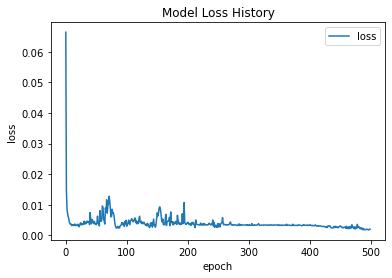

In [271]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [272]:
train_predict3 = model3.predict(X_train3, batch_size=batch_size)

359/359 [==============================] - 1s 2ms/step


In [273]:
days_to_predict3 = X_test3.shape[0]
test_predict3 = []
pred_samples3 = train_predict3[-1:]
pred_samples3 = np.array([pred_samples3])
for i in range(days_to_predict3):
    pred3 = model3.predict(X_test3[i:(i+1)], batch_size=batch_size)
    pred3 = np.array(pred3).flatten()
    test_predict3.append(pred3)
test_predict3 = np.array(test_predict3).reshape(1, len(test_predict3), 1)

1/1 [==============================] - 0s 16ms/step


In [274]:
model3.reset_states()

In [275]:
X_train_flatten3 = np.array(scaler.inverse_transform(
    np.array(X_train3).reshape(X_train3.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten3 = np.array(scaler.inverse_transform(
    np.array(Y_train3).reshape(Y_train3.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(train_predict3).reshape(train_predict3.shape[0], 1)
)).flatten().astype('int')
X_test_flatten3 = np.array(scaler.inverse_transform(
    np.array(X_test3).reshape(X_test3.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten3 = np.array(scaler.inverse_transform(
    np.array(Y_test3).reshape(Y_test3.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(test_predict3).reshape(test_predict3.shape[1], 1)
)).flatten().astype('int')

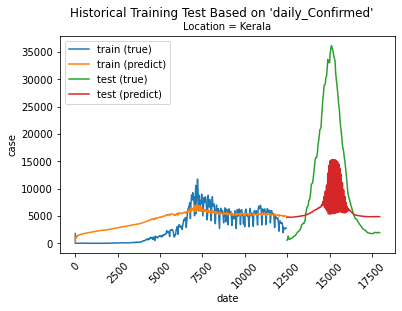

In [276]:
plt.plot(
    cases3.index[:len(X_train_flatten3)],
    X_train_flatten3,
    label='train (true)'
)
plt.plot(
    cases3.index[:len(train_predict_flatten3)],
    train_predict_flatten3,
    label='train (predict)'
)
plt.plot(
    cases3.index[len(X_train_flatten3):len(X_train_flatten3) + len(X_test_flatten3)],
    X_test_flatten3,
    label='test (true)'
)
plt.plot(
    cases3.index[len(X_train_flatten3):len(X_train_flatten3) + len(test_predict_flatten3)],
    test_predict_flatten3,
    label='test (predict)'
)
plt.suptitle('Historical Training Test Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [277]:
model3.reset_states()

In [278]:
epoch = EPOCHS
loss = []

for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model3.fit(X_all3, Y_all3, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h3 = model3.history
    loss.append(h3.history['loss'][0])
    
    model3.reset_states()

Iteration 1/500
513/513 [==============================] - 2s 3ms/step - loss: 0.0343
Iteration 2/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0422
Iteration 3/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0359
Iteration 4/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0253
Iteration 5/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0218
Iteration 6/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0186
Iteration 7/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0155
Iteration 8/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0169
Iteration 9/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0153
Iteration 10/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0143
Iteration 11/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0119
Iteration 12/500
513/513 [==========================

513/513 [==============================] - 1s 2ms/step - loss: 0.0058
Iteration 189/500
513/513 [==============================] - 2s 4ms/step - loss: 0.0049
Iteration 190/500
513/513 [==============================] - 2s 4ms/step - loss: 0.0059
Iteration 191/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0052
Iteration 192/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0055
Iteration 193/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0055
Iteration 194/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0053
Iteration 195/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0055
Iteration 196/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0055
Iteration 197/500
513/513 [==============================] - 2s 4ms/step - loss: 0.0056
Iteration 198/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0050
Iteration 199/500
513/513 [=======================

513/513 [==============================] - 1s 2ms/step - loss: 0.0031
Iteration 375/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0033
Iteration 376/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0031
Iteration 377/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0037
Iteration 378/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0038
Iteration 379/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0029
Iteration 380/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0032
Iteration 381/500
513/513 [==============================] - 1s 2ms/step - loss: 0.0035
Iteration 382/500
513/513 [==============================] - 2s 3ms/step - loss: 0.0031
Iteration 383/500
513/513 [==============================] - 1s 3ms/step - loss: 0.0039
Iteration 384/500
513/513 [==============================] - 2s 3ms/step - loss: 0.0037
Iteration 385/500
513/513 [=======================

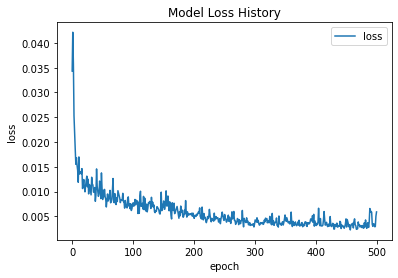

In [279]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [280]:
all_predict3 = model3.predict(X_all3, batch_size=batch_size)

513/513 [==============================] - 1s 2ms/step


In [281]:
days_to_predict3 = DAYS_TO_PREDICT
future_predict3 = []
pred_samples3 = all_predict3[-1:]
pred_samples3 = np.array([pred_samples3])
for i in range(days_to_predict3):
    pred3 = model3.predict(pred_samples3, batch_size=batch_size)
    pred3 = np.array(pred3).flatten()
    future_predict3.append(pred3)
    new_samples3 = np.array(pred_samples3).flatten()
    new_samples3 = np.append(new_samples3, [pred3])
    new_samples3 = new_samples3[1:]
    pred_samples3= np.array(new_samples3).reshape(1, 1, 1)
future_predict3= np.array(future_predict3).reshape(len(future_predict3), 1, 1)

1/1 [==============================] - 0s 16ms/step


In [282]:
model3.reset_states()

In [283]:
f_future_predict3 = model3.predict(future_predict3, batch_size=batch_size)

30/30 [==============================] - 0s 2ms/step


In [284]:
model3.reset_states()

In [285]:
X_all_flatten3 = np.array(scaler.inverse_transform(
    np.array(X_all3).reshape(X_all3.shape[0], 1)
)).flatten().astype('int')
X_all_flatten3= np.absolute(X_all_flatten3)
Y_all_flatten3 = np.array(scaler.inverse_transform(
    np.array(Y_all3).reshape(Y_all3.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten3 = np.absolute(Y_all_flatten3)
all_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(all_predict3).reshape(all_predict3.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten3 = np.absolute(all_predict_flatten3)
future_predict_flatten3 = np.array(scaler.inverse_transform(
    np.array(future_predict3).reshape(future_predict3.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten3 = np.absolute(future_predict_flatten3)
f_future_predict_flatten3= np.array(scaler.inverse_transform(
    np.array(f_future_predict3).reshape(f_future_predict3.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten3 = np.absolute(f_future_predict_flatten3)

In [286]:
future_index3 = pd.date_range(start=cases3.index[-1], periods=days_to_predict3 + 1, closed='right')

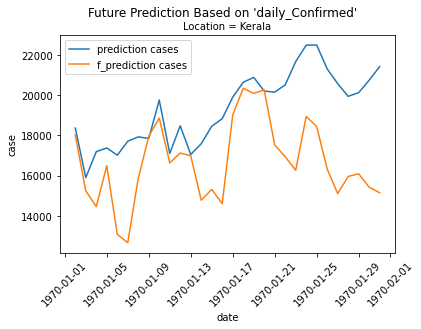

In [287]:
plt.plot(
    future_index3,
    future_predict_flatten3,
    label='prediction cases'
)
plt.plot(
    future_index3,
    f_future_predict_flatten3,
    label='f_prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

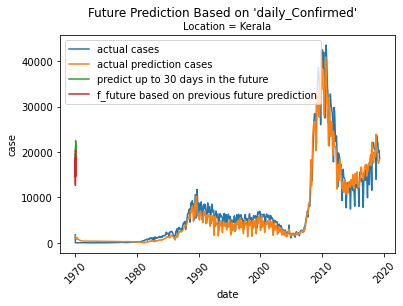

In [288]:
plt.plot(
    cases3.index[:len(X_all_flatten3)],
    X_all_flatten3,
    label='actual cases'
)
plt.plot(
    cases3.index[:len(X_all_flatten3)],
    all_predict_flatten3,
    label='actual prediction cases'
)
plt.plot(
    future_index3,
    future_predict_flatten3,
    label='predict up to ' + str(days_to_predict) + ' days in the future'
)
plt.plot(
    future_index3,
    f_future_predict_flatten3,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [356]:
#kerala
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i]<35):
            count += 1
           
    return count/len(DataY)
accuracy( Y_all_flatten3, 
        all_predict_flatten3)

0.9142300194931774